In [ ]:
#-------------------------------- part 1 #--------------------------------

In [ ]:
!pip install gymnasium matplotlib


In [ ]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# Environment setup
env = gym.make("Taxi-v3")
state_space_size = env.observation_space.n  # 500
action_space_size = env.action_space.n      # 6

In [ ]:
# Q-table initialization
q_table = np.zeros((state_space_size, action_space_size))

# Hyperparameters
alpha = 0.8            # Learning rate
gamma = 0.95           # Discount factor
epsilon = 1.0          # Exploration rate
min_epsilon = 0.01
epsilon_decay = 0.999
episodes = 5000
test_episodes = 100
max_steps = 100        # per episode

# Rewards tracking
rewards_per_episode = []


In [ ]:
# Training loop
for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        # Exploration-exploitation
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update Q-table
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state, :])
        q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay epsilon after 2000 episodes
    if episode >= 2000:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    rewards_per_episode.append(total_reward)


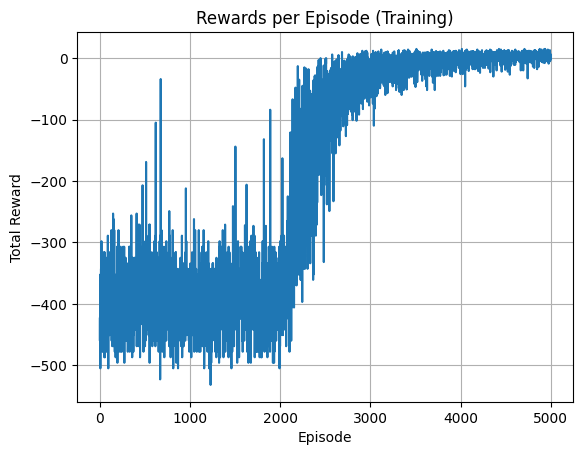

In [ ]:
# Plot training rewards
plt.plot(rewards_per_episode)
plt.title("Rewards per Episode (Training)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [ ]:
# Testing the trained agent
total_test_reward = 0
for _ in range(test_episodes):
    state, _ = env.reset()
    test_episode_reward = 0
    done = False

    for _ in range(max_steps):
        action = np.argmax(q_table[state, :])  # greedy action
        state, reward, terminated, truncated, _ = env.step(action)
        test_episode_reward += reward
        done = terminated or truncated
        if done:
            break

    total_test_reward += test_episode_reward

average_test_reward = total_test_reward / test_episodes
print(f"\nAverage reward over {test_episodes} test episodes: {average_test_reward:.2f}")


Average reward over 100 test episodes: 8.11


In [ ]:
#-------------------------------- part 2 --------------------------------

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import random
import optuna
import matplotlib.pyplot as plt

def train_q_learning(alpha=0.8, gamma=0.95, gamma_test=1.0, epsilon=1.0, epsilon_decay=0.999,
                     min_epsilon=0.01, episodes=5000, test_episodes=100,
                     max_steps=200, decay_start_episode=3000, exploration_strategy="exp_decay", plot=False):

    env = gym.make("Taxi-v3")
    state_space_size = env.observation_space.n
    action_space_size = env.action_space.n
    q_table = np.zeros((state_space_size, action_space_size))
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        for _ in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state, :])
            q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

            state = next_state
            total_reward += reward

            if done:
                break

        if episode >= decay_start_episode:
            if exploration_strategy == "exp_decay":
                epsilon = max(min_epsilon, epsilon * epsilon_decay)
            elif exploration_strategy == "linear_decay":
                epsilon = max(min_epsilon, epsilon - 0.001)
            # "constant" -> no decay

        rewards_per_episode.append(total_reward)

    if plot:
        plt.plot(rewards_per_episode)
        plt.title("Rewards per Episode (Training)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.grid(True)
        plt.show()

    total_test_reward = 0
    for _ in range(test_episodes):
        state, _ = env.reset()
        test_episode_reward = 0
        done = False
        for _ in range(max_steps):
            action = np.argmax(q_table[state, :])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Optional: apply gamma_test discounting manually here if needed
            test_episode_reward += reward
            state = next_state

            if done:
                break
        total_test_reward += test_episode_reward

    average_test_reward = total_test_reward / test_episodes
    return average_test_reward

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.4, 0.8)
    gamma = trial.suggest_float("gamma", 0.85, 0.99)
    gamma_test = trial.suggest_float("gamma_test", 0.95, 1.0)
    epsilon = trial.suggest_float("epsilon", 0.8, 1.0)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.95, 0.9999)
    min_epsilon = trial.suggest_float("min_epsilon", 0.01, 0.1)
    episodes = trial.suggest_int("episodes", 10000, 15000)
    max_steps = trial.suggest_int("max_steps", 100, 400)
    decay_start_episode = trial.suggest_int("decay_start_episode", 2000, 8000)
    test_episodes = trial.suggest_int("test_episodes", 100, 300)
    exploration_strategy = trial.suggest_categorical("exploration_strategy", ["exp_decay", "linear_decay", "constant"])

    return train_q_learning(
        alpha=alpha,
        gamma=gamma,
        gamma_test=gamma_test,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=min_epsilon,
        episodes=episodes,
        test_episodes=test_episodes,
        decay_start_episode=decay_start_episode,
        max_steps=max_steps,
        exploration_strategy=exploration_strategy,
        plot=False
    )

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-10 14:35:47,859] A new study created in memory with name: no-name-099a7bba-cf05-4190-ba56-b441d63fb44a
[I 2025-05-10 14:36:19,580] Trial 0 finished with value: 7.6 and parameters: {'alpha': 0.618829090953706, 'gamma': 0.9554523306833166, 'gamma_test': 0.9588590187073176, 'epsilon': 0.9996688531892612, 'epsilon_decay': 0.9605039184939606, 'min_epsilon': 0.06002273685314178, 'episodes': 13942, 'max_steps': 257, 'decay_start_episode': 6455, 'test_episodes': 242, 'exploration_strategy': 'exp_decay'}. Best is trial 0 with value: 7.6.
[I 2025-05-10 14:36:46,644] Trial 1 finished with value: 7.64 and parameters: {'alpha': 0.544105970301698, 'gamma': 0.986549103345159, 'gamma_test': 0.9552243170456803, 'epsilon': 0.9116685339836949, 'epsilon_decay': 0.9939868193823014, 'min_epsilon': 0.048503065892498025, 'episodes': 13290, 'max_steps': 391, 'decay_start_episode': 5992, 'test_episodes': 285, 'exploration_strategy': 'exp_decay'}. Best is trial 1 with value: 7.64.
[I 2025-05-10 14:37:

In [ ]:
best_params = study.best_params
best_reward = study.best_value

In [ ]:
print("\nBest hyperparameters:")
print(best_params)
print(f"Best average reward: {best_reward:.2f}")


Best hyperparameters:
{'alpha': 0.5921159756744235, 'gamma': 0.891156247145646, 'gamma_test': 0.9577110507831884, 'epsilon': 0.9993703680724215, 'epsilon_decay': 0.9768000277385556, 'min_epsilon': 0.09364653919350596, 'episodes': 11448, 'max_steps': 223, 'decay_start_episode': 4821, 'test_episodes': 272, 'exploration_strategy': 'linear_decay'}
Best average reward: 8.43


In [ ]:
#-------------------------------- part 3 --------------------------------

In [ ]:
#-------------------------------- without Optuna --------------------------------
# 6x6
# drop-off 8 points
# custom award system

In [13]:
import gymnasium as gym
from gymnasium.envs.toy_text.taxi import TaxiEnv
import numpy as np
import random
import optuna
import matplotlib.pyplot as plt

# Define custom 6x6 Taxi environment with more pickup/drop-off points and custom rewards
class TaxiEnv6x6(TaxiEnv):
    def __init__(self):
        self.desc = np.array([
            "+---------+---------+---------+---------+---------+---------+",
            "| : |   : | :   : |   :   : | :   : |   :   : |",
            "+ : +---:+---:+ : +---:+ : +---:+ : +---:+ : +",
            "|   :   : |   :   : |   :   : |   :   : |   :   : |",
            "+---:+ : +---:+ : +---:+ : +---:+ : +---:+ : +",
            "| :   : | :   : | :   : | :   : | :   : | :   : |",
            "+ : +---:+ : +---:+ : +---:+ : +---:+ : +---:+",
            "|   :   : |   :   : |   :   : |   :   : |   :   : |",
            "+---:+ : +---:+ : +---:+ : +---:+ : +---:+ : +",
            "| :   : | :   : | :   : | :   : | :   : | :   : |",
            "+---------+---------+---------+---------+---------+---------+"
        ])
        self.rows = 6
        self.cols = 6
        self.locs = [
            (0, 0),  # Red
            (0, 5),  # Green
            (5, 0),  # Blue
            (5, 5),  # Yellow
            (2, 2),  # New: Center
            (3, 3),  # New: Lower-middle
            (1, 4),  # New: Right-top
            (4, 1)   # New: Left-bottom
        ]
        super().__init__()

    def step(self, action):
        """Override to customize reward structure."""
        state = self.s
        transitions = self.P[state][action]
        prob, next_state, base_reward, terminated = transitions[0]  # Taxi is deterministic

        # Modify reward structure
        if base_reward == -10:  # Invalid pickup/drop-off
            reward = -20
        elif base_reward == 20:  # Successful drop-off
            reward = 50
        else:
            reward = base_reward

        self.s = next_state
        self.lastaction = action
        return next_state, reward, terminated, False, {"prob": prob}


def train_q_learning(alpha=0.8, gamma=0.95, gamma_test=1.0, epsilon=1.0, epsilon_decay=0.999,
                     min_epsilon=0.01, episodes=5000, test_episodes=100,
                     max_steps=200, decay_start_episode=3000, exploration_strategy="exp_decay", plot=False):

    env = TaxiEnv6x6()  # ✅ Use custom 6x6 environment
    state_space_size = env.observation_space.n
    action_space_size = env.action_space.n
    q_table = np.zeros((state_space_size, action_space_size))
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        for _ in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state, :])
            q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

            state = next_state
            total_reward += reward

            if done:
                break

        if episode >= decay_start_episode:
            if exploration_strategy == "exp_decay":
                epsilon = max(min_epsilon, epsilon * epsilon_decay)
            elif exploration_strategy == "linear_decay":
                epsilon = max(min_epsilon, epsilon - 0.001)
            # "constant" -> no decay

        rewards_per_episode.append(total_reward)

    if plot:
        plt.plot(rewards_per_episode)
        plt.title("Rewards per Episode (Training)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.grid(True)
        plt.show()

    total_test_reward = 0
    for _ in range(test_episodes):
        state, _ = env.reset()
        test_episode_reward = 0
        done = False
        for _ in range(max_steps):
            action = np.argmax(q_table[state, :])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            test_episode_reward += reward
            state = next_state
            if done:
                break
        total_test_reward += test_episode_reward

    average_test_reward = total_test_reward / test_episodes
    return average_test_reward


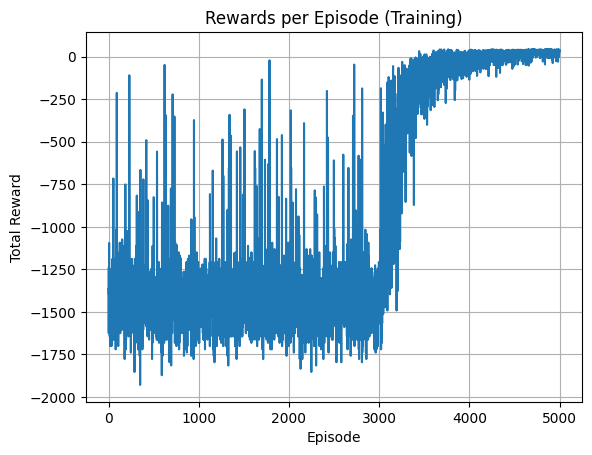


✅ Average Test Reward on drop off points: 38.19


In [14]:
if __name__ == "__main__":
    avg_reward = train_q_learning(
        alpha=0.8,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.999,
        min_epsilon=0.01,
        episodes=5000,
        test_episodes=100,
        max_steps=200,
        decay_start_episode=3000,
        exploration_strategy="exp_decay",
        plot=True  # Set to False if you don't want to see the plot
    )

    print(f"\n✅ Average Test Reward on drop off points: {avg_reward:.2f}")


In [ ]:
#-------------------------------- with Optuna --------------------------------

# 6x6
# drop-off 8 points
# custom award system

In [12]:
import gymnasium as gym
from gymnasium.envs.toy_text.taxi import TaxiEnv
import numpy as np
import random
import optuna
import matplotlib.pyplot as plt

# Define custom 6x6 Taxi environment
# Define custom 6x6 Taxi environment with extra pickup/drop-off points
# Define custom 6x6 Taxi environment with more pickup/drop-off points and custom rewards
class TaxiEnv6x6(TaxiEnv):
    def __init__(self):
        self.desc = np.array([
            "+---------+---------+---------+---------+---------+---------+",
            "| : |   : | :   : |   :   : | :   : |   :   : |",
            "+ : +---:+---:+ : +---:+ : +---:+ : +---:+ : +",
            "|   :   : |   :   : |   :   : |   :   : |   :   : |",
            "+---:+ : +---:+ : +---:+ : +---:+ : +---:+ : +",
            "| :   : | :   : | :   : | :   : | :   : | :   : |",
            "+ : +---:+ : +---:+ : +---:+ : +---:+ : +---:+",
            "|   :   : |   :   : |   :   : |   :   : |   :   : |",
            "+---:+ : +---:+ : +---:+ : +---:+ : +---:+ : +",
            "| :   : | :   : | :   : | :   : | :   : | :   : |",
            "+---------+---------+---------+---------+---------+---------+"
        ])
        self.rows = 6
        self.cols = 6
        self.locs = [
            (0, 0),  # Red
            (0, 5),  # Green
            (5, 0),  # Blue
            (5, 5),  # Yellow
            (2, 2),  # New: Center
            (3, 3),  # New: Lower-middle
            (1, 4),  # New: Right-top
            (4, 1)   # New: Left-bottom
        ]
        super().__init__()

    def step(self, action):
        """Override to customize reward structure."""
        state = self.s
        transitions = self.P[state][action]
        prob, next_state, base_reward, terminated = transitions[0]  # Taxi is deterministic

        # Modify reward structure
        if base_reward == -10:  # Invalid pickup/drop-off
            reward = -20
        elif base_reward == 20:  # Successful drop-off
            reward = 50
        else:
            reward = base_reward

        self.s = next_state
        self.lastaction = action
        return next_state, reward, terminated, False, {"prob": prob}


# Training function with parameters
def train_q_learning(alpha=0.8, gamma=0.95, gamma_test=1.0, epsilon=1.0, epsilon_decay=0.999,
                     min_epsilon=0.01, episodes=5000, test_episodes=100,
                     max_steps=200, decay_start_episode=3000, exploration_strategy="exp_decay", plot=False):

    env = TaxiEnv6x6()
    state_space_size = env.observation_space.n
    action_space_size = env.action_space.n
    q_table = np.zeros((state_space_size, action_space_size))
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        for _ in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state, :])
            q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

            state = next_state
            total_reward += reward

            if done:
                break

        if episode >= decay_start_episode:
            if exploration_strategy == "exp_decay":
                epsilon = max(min_epsilon, epsilon * epsilon_decay)
            elif exploration_strategy == "linear_decay":
                epsilon = max(min_epsilon, epsilon - 0.001)

        rewards_per_episode.append(total_reward)

    if plot:
        plt.plot(rewards_per_episode)
        plt.title("Rewards per Episode (Training)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.grid(True)
        plt.show()

    total_test_reward = 0
    for _ in range(test_episodes):
        state, _ = env.reset()
        test_episode_reward = 0
        done = False
        for _ in range(max_steps):
            action = np.argmax(q_table[state, :])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            test_episode_reward += reward
            state = next_state
            if done:
                break
        total_test_reward += test_episode_reward

    average_test_reward = total_test_reward / test_episodes
    return average_test_reward

# Optuna objective function
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.4, 0.8)
    gamma = trial.suggest_float("gamma", 0.85, 0.99)
    gamma_test = trial.suggest_float("gamma_test", 0.95, 1.0)
    epsilon = trial.suggest_float("epsilon", 0.8, 1.0)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.95, 0.9999)
    min_epsilon = trial.suggest_float("min_epsilon", 0.01, 0.1)
    episodes = trial.suggest_int("episodes", 10000, 15000)
    max_steps = trial.suggest_int("max_steps", 100, 400)
    decay_start_episode = trial.suggest_int("decay_start_episode", 2000, 8000)
    test_episodes = trial.suggest_int("test_episodes", 100, 300)
    exploration_strategy = trial.suggest_categorical("exploration_strategy", ["exp_decay", "linear_decay", "constant"])

    return train_q_learning(
        alpha=alpha,
        gamma=gamma,
        gamma_test=gamma_test,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=min_epsilon,
        episodes=episodes,
        test_episodes=test_episodes,
        max_steps=max_steps,
        decay_start_episode=decay_start_episode,
        exploration_strategy=exploration_strategy,
        plot=False
    )

# Run Optuna Study
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    best_params = study.best_params
    best_reward = study.best_value

    print("\n✅ Best hyperparameters found by Optuna:")
    for k, v in best_params.items():
        print(f"{k}: {v}")
    print(f"\n🏆 Best average reward on test episodes: {best_reward:.2f}")


[I 2025-05-10 18:03:44,083] A new study created in memory with name: no-name-f884cef6-7096-4be1-be43-d9748abfa54c
[I 2025-05-10 18:03:54,959] Trial 0 finished with value: 37.916666666666664 and parameters: {'alpha': 0.4698079052424803, 'gamma': 0.8975600040994984, 'gamma_test': 0.9791176707189762, 'epsilon': 0.8626999431871588, 'epsilon_decay': 0.9650807853415893, 'min_epsilon': 0.07236512131703754, 'episodes': 11459, 'max_steps': 110, 'decay_start_episode': 7983, 'test_episodes': 192, 'exploration_strategy': 'linear_decay'}. Best is trial 0 with value: 37.916666666666664.
[I 2025-05-10 18:04:21,499] Trial 1 finished with value: 37.9874213836478 and parameters: {'alpha': 0.5330835531040314, 'gamma': 0.9861134551064035, 'gamma_test': 0.9601352747604642, 'epsilon': 0.9182149244915007, 'epsilon_decay': 0.9852944203769326, 'min_epsilon': 0.09471898451742444, 'episodes': 13535, 'max_steps': 175, 'decay_start_episode': 5299, 'test_episodes': 159, 'exploration_strategy': 'constant'}. Best is 


✅ Best hyperparameters found by Optuna:
alpha: 0.7821397026321074
gamma: 0.8719702407356612
gamma_test: 0.9846349112065946
epsilon: 0.9788669117525621
epsilon_decay: 0.9991813245933937
min_epsilon: 0.05611337076007234
episodes: 12541
max_steps: 177
decay_start_episode: 5385
test_episodes: 101
exploration_strategy: linear_decay

🏆 Best average reward on test episodes: 38.14
